# Miniproject 2: Chatbot

## Introduction

### Description

Developing a model employing ANN on real-world data requires going through several major steps, each of which with 
important design choices that directly impact the final results. 
In this project, we guide you through these choices starting from a large database of 
[conversations](http://parl.ai/downloads/personachat/personachat.tgz) to a functional chatbot. 

### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night and make sure you save (and load) your data and models.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. 
Please ensure that your notebook is fully executed before handing it in. 

### Submission 

You should submit your notebook through the Moodle page submission tool. You should work in teams of two people and each member should submit the same notebook to Moodle.



## Functions and imports

For your convenience we import some libraries and provide some functions below. Fill in your names, sciper numbers and run the following cell.

In [0]:
names = {'student_1': "Jiahua WU",
        'student_2': "Lingjing KONG"}

sciper = {'student_1': 293807, 
          'student_2': 292267}

seed = sciper['student_1']+sciper['student_2']

%matplotlib inline

import random 
random.seed(seed)
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import copy
import collections
import pandas as pd
import pickle

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN, Bidirectional, Embedding, BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping

def getRawDataFromFile(datapath="data/personachat/", file="train_both_revised.txt"):
    
    f = open(datapath+file)

    conversations = []
    current_conversation = []
    
    for l, line in enumerate(f):
        #print(l, line)
        if "persona:" in line:
            if len(current_conversation) > 1:
                conversations.append(current_conversation)
            current_conversation = [] 
            continue

        #remove numberings
        processed_line = line.split(' ')
        processed_line = " ".join(processed_line[1:])
        line = processed_line
        #print(line)

        conv = line.split('\t')    
        q = conv[0]
        a = conv[1]
        current_conversation.append(q)
        current_conversation.append(a)
    
    return conversations 

## Data visualization and preprocessing

Here we will process and visualize the data.


### Parse raw data 

Download the dataset on http://parl.ai/downloads/personachat/personachat.tgz. Unpack it and add it to your project folder. Read and run the getRawDataFromFile function (if needed, modify the default path). It extracts the conversations.

**Output** Display two randomly selected conversations. [1 pt]

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# load in the conversations
conversations = getRawDataFromFile(datapath='/content/gdrive/My Drive/Colab Notebooks/personachat/')

In [0]:
# display two randomly selected conversations
print(conversations[6])
print(conversations[66])

['rock on , i am listening to my favorite band guns and roses .', 'no kidding ? i was just listening to the same thing while taking a bath .', 'of course . i love to listen to rock .', 'man my boxer just peed on the carpet !', 'well i am into black everything . so at least it would not show on my black carpet .', 'll . i love black too ! guess i was playing my music too loud .', 'i have a black car , purse , wear all black .', 'maybe i can borrow something as i am packing to visit my dad in china .', 'wow , does he live there or work ?', 'live . moved there about ten years ago for a computer tech job .', 'have you visited him there before ?', 'once . you cannot even throw a gum wrapper or you can get arrested .', 'sounds a bit scary . i ve never been .', 'well not too much crime there , but a lot of people .']
['hi there ! do you watch got ?', 'i do ! i am only on season 3 so far though .', 'you will be blown away by the ending ! i love that show .', 'i really like it so far . i enjoy 

### Extract word tokens

Let's start looking at our data. 

**Code** Compute the set of unique words (dictionary) in all sentences along with the number of occurences of each of these words. HINT: each word is separated by a space character, use the python string.split(' ') function to separate words. Consider punctuations as 'words'. [1 pt]

**Figure** In a bar plot, show the first 75 most frequent words (x-axis) and their number of occurences (y-axis). [1 pt]

**Figure** In another bar plot, show the 75 least frequent words (x-axis) and their number of occurences (y-axis). [1 pt] 

**Figure** In a log-log scale, plot the sorted word index (x-axis) vs their respective count (y-axis). [1 pt]

**Question** Relate the sorted word count distribution with Zipf's law.
Argue using the log-log plot. [1 pt]

**Answer**: **Our world distribution follows the Zipf's law where the frequency of 
any word is approximatley inversely proportional to its rank in the frequency table.**

**Question** How many words appear only once in the entire dataset? [1 pt]

**Answer**: **7080**



#### Compute the set of unique words (dictionary) in all sentences along with the number of occurences of each of these words. HINT: each word is separated by a space character, use the python string.split(' ') function to separate words. Consider punctuations as 'words'. [1 pt]

In [0]:
# intialize storage
dictionary = dict()

# traverse each sentence to collect words
for conversation in conversations:
    for sentence in conversation:
        for word in sentence.split(' '):
            if word not in dictionary.keys():
                dictionary[word] = 1
            else:
                dictionary[word] += 1

#### In a bar plot, show the first 75 most frequent words (x-axis) and their number of occurences (y-axis). [1 pt]

In [0]:
# create a counter and sort words by their frequencies
word_counter = collections.Counter(dictionary)
sorted_words = word_counter.most_common()

[]

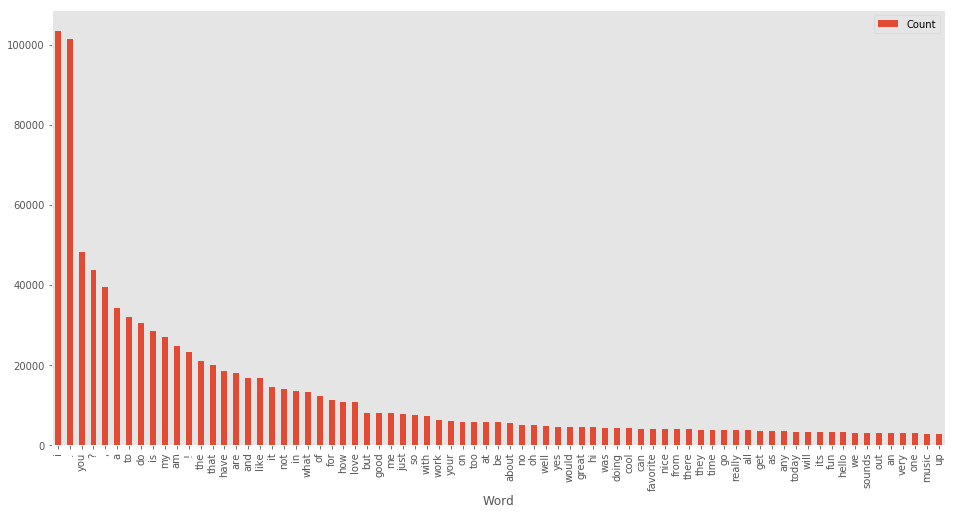

In [0]:
# plot the 75 most common ones
most_75 = sorted_words[: 75]
df_most_75 = pd.DataFrame(most_75, columns = ['Word', 'Count'])
df_most_75.plot.bar(x='Word',y='Count', figsize=(16, 8))
plt.plot()

#### In another bar plot, show the 75 least frequent words (x-axis) and their number of occurences (y-axis). [1 pt] 

[]

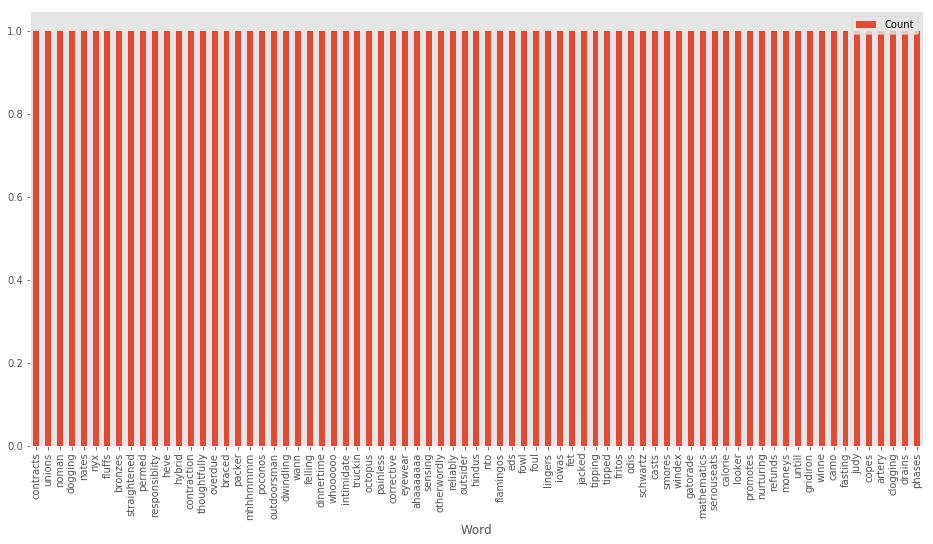

In [0]:
# plot the 75 least common ones
least_75 = sorted_words[-75: ]
df_least_75 = pd.DataFrame(least_75, columns = ['Word', 'Count'])
df_least_75.plot.bar(x='Word',y='Count', figsize=(16, 8))
plt.plot()

#### In a log-log scale, plot the sorted word index (x-axis) vs their respective count (y-axis). [1 pt]

In [0]:
# get the sorted frequency
frequency_list = list(map(lambda x: x[1], sorted_words))

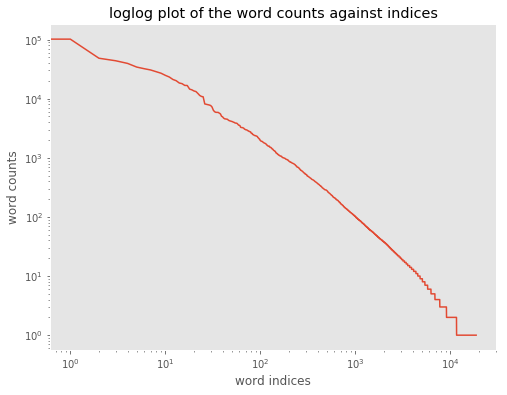

In [0]:
# plot in a log-log scale
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('loglog plot of the word counts against indices')
ax.set_xlabel('word indices')
ax.set_ylabel('word counts')
ax.loglog(frequency_list)
plt.show()

In [0]:
# count words that only appear once
one_appearance_count = 0
for word_count in word_counter.values():
    if word_count == 1:
        one_appearance_count += 1

print('The number of words that only appear once is', one_appearance_count)

The number of words that only appear once is 7080


### Filtering

We suggest to filter your data by removing sentences containing rare words. 


**Code** To achieve that, you should create a new dataset where sentences containing rare words (words that occur less than N times in the dataset) are removed. Keep at least 50'000 sentences (depending on your computing power, you can keep more). 
HINT: Start by updating the dictionary accordingly and then remove any sentence that contains at least a single word that is not in the dictionary of words. [2 pts]

**Question**: How much did you reduce the number of unique words with your rare event suppression procedure? [1 pt]
    
**Answer**: **We get rid of 17661 rare words.**

**Question**: How many sentences are in your filtered and original dataset? [1 pt]

**Answer**: **51008 in the filtered dataset; 131424 in the orginial dataset.**

**Question**: What is the impact on learning and generalization of removing sentences with rare words from your dataset? [2 pt]

**Answer**: 

**During learning, the removal of sentences with rare words will prevent the model from overfitting the rare words (as they only appear once, the model will memorize these specific cases), and will also save training time (less data).** 

**On the other hand, if rare words appear in the validation/test stage, the model may not have corresponding embedding for them (not having encountered them during training), this will harm model preformance dramatically. Overally removing setences with rare words helps improve the model generalization.**

In [0]:
# words with frequency lower than N get removed
N = 100
        
# prune the dictionary
pruned_dict = dict()
for word, count in dictionary.items():
    if count >= N:
        pruned_dict[word] = count

# remove senetences
pruned_conv = copy.deepcopy(conversations)
for conv_id in range(len(conversations)):
    for sentence in conversations[conv_id]:
        flag = 0
        for word in sentence.split():
            if word not in pruned_dict.keys():
                flag = 1
        if flag == 1:
            pruned_conv[conv_id].remove(sentence)


In [0]:
# check how many words get deleted
len(list(dictionary.keys())) - len(list(pruned_dict.keys()))

17661

In [0]:
# the number of sentences in the filtered dataset and the orginal dataset
filter_sentence_count = 0
original_sentence_count = 0
for pruned_conversation, conversation in zip(pruned_conv, conversations):
    original_sentence_count += len(conversation)
    filter_sentence_count += len(pruned_conversation)

print('The number of sentences in the filtered dataset is ' + str(filter_sentence_count))
print('The number of sentences in the original dataset is ' + str(original_sentence_count))

The number of sentences in the filtered dataset is 51008
The number of sentences in the original dataset is 131424


### Tokenization and padding

Now you will transform our filtered data into a format that is understandable by an ANN. To achieve that, you should transform words to integers, where single integers in the range [1,size of the dictionary] are mapped to single words in your dictionary. This process is commonly named 'tokenization'. In addition, we will keep the value 0 to a specific artificial word 'PADD' that will be used to account for the variable length of sentences and add to each sentence a 'START' and an 'END' word. 

**Code** Start by adding the three artificial words to your dictionary (list of possible tokens) and then translate every sentences to a list of integers. 
HINT: use the Python List index() method. [2 pts]

**Figure** Use the violinplot to show the density of tokenized sentences length. [1pt]

**Code** From this figure, select a maximum number (=maxlen) of tokens for which most of the sentences have less. Padd (and eventually truncate) all sentences with the 'PADD' token (value 0 in the integer representation) until all tokenized sentences have the same length (maxlen).
HINT: use the pad_sequences function from keras.preprocessing.sequence [2 pts]

**Code** Check that you can recover the original sentence. Randomly select two sentences from your integer and padded representation and translate them back using your dictionary. [1 pt]

#### Create dictionary list and perform translation for each sentence.

In [0]:
# the dictionary list
dict_list = list(pruned_dict.keys())

# insert the three words
dict_list.insert(0, 'PADD')
dict_list.append('START')
dict_list.append('END')

In [0]:
# add 'START' and 'END' to each sentence 
filtered_sentences = ['START ' + line + ' END' for one_conversation in pruned_conv for line in one_conversation]

# translation
tokenized_setences = list()
for one_sentence in filtered_sentences:
    tokenized_setences.append(list(map(lambda word: dict_list.index(word), one_sentence.split(' '))))

#### Use violin plot to show the density of tokenized sentence lengths

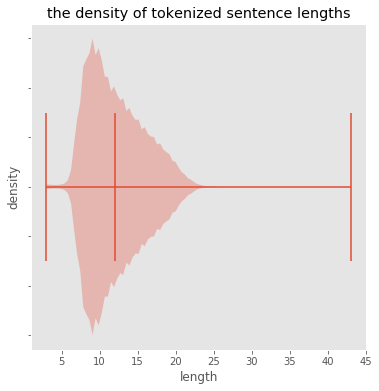

In [0]:
# length of each sentence (with 'START' and 'END')
lengths = [len(one_line.split()) for one_line in filtered_sentences]

# violin plot
fig = plt.figure(num=1, figsize=(6, 6))
ax = fig.add_subplot(111)
ax.violinplot(lengths, points=100, widths=0.6, vert=False,
              showmeans=True, showextrema=True, showmedians=False)
ax.set_title('the density of tokenized sentence lengths')
ax.set_yticklabels([])
ax.set_xlabel('length')
ax.set_ylabel('density')
plt.show()

#### Padding

choose max_len to be 23 from the violin plot as inidicated from above violin plot

In [0]:
# post padding (truncation)
maxlen = 23
padded_token_sentences = pad_sequences(tokenized_setences, maxlen=maxlen, dtype='int32', padding='post', truncating='post', value=0)

#### Translate back randomly selected sentences

In [0]:
# random integers
ind1 = random.randrange(start=0, stop=len(padded_token_sentences))
ind2 = random.randrange(start=0, stop=len(padded_token_sentences))

# translate back 
translation1 = list(map(lambda token: dict_list[token], padded_token_sentences[ind1]))
print(' '.join(translation1))
translation2 = list(map(lambda token: dict_list[token], padded_token_sentences[ind2]))
print(' '.join(translation2))

START maybe , do we have anything in common ? END PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD
START being a mom of two kids , i have enough exercise everyday END PADD PADD PADD PADD PADD PADD PADD PADD PADD


### Saving

Now is a good time to save your data (end of processing). An example code using the pickle library is shown below.


In [0]:
#save
with open("/content/gdrive/My Drive/Colab Notebooks/processed_data.pkl", "wb") as file:
    pickle.dump([filtered_sentences, dict_list, padded_token_sentences], file)

In [0]:
#load
with open("/content/gdrive/My Drive/Colab Notebooks/processed_data.pkl", "rb") as file:
    [filtered_sentences, dict_list, padded_token_sentences] = pickle.load(file)

## Building and training generative models of language

### RNN vs LSTM vs GRU 

Build, train and compare generative models of language based on RNNs with different recurrent units (SimpleRNN, GRU and LSTM). 

The target of the network will be to approximate the word transition probabilities Pr(word[n+1]|H[n]) with H[n]=f(word[:n]) being the hidden state of the network.  

**code** You should complete the proposed model (using the Keras API rather than the Sequential model for more flexibility). Be sure to understand each line. The embedding layer allows to transform an integer to a dense vector. That would be our input to the recurrent network - each sentence is mapped to a sequence of vectors, each representing a single word. You can then design your own readout(s) and output layers. By default, use the proposed meta parameters. You can adapt them if you have more or less computing power (32 epochs should take around 30 minutes). [2 pts]

**Question** How will your networks deal with the artificial word 'PADD' that you added at the end of each sentences  [2 pts]

**Answer**: 'PADD' tokens will be igored by layers after the embedding layer as the option 'mask_zero' on embedding is set True. 'PADD' with index 0 will be masked out. 

**code** Then train three different networks with the same architecture but using different recurrent units (simpleRNN, GRU and LSTM). Save the learning history (training/validation loss and accuracy for each epoch) as well as the models. [1 pt]

**Question** How can you use this network to approximate the word transition probabilities? What will be the inputs and targets of the network at each batch? Give the input/output tensor dimensions. [2 pts]

**Answer** 

We set the recurrent unit to return sequence and use Timedistributed readout/output layer, therefore at each step the input is the sequence word[:n], the softmax output is the the transition probabilty distribution Pr(word[n+1]|word[:n]).

Each training sample in a batch is a tokenized sentence without the last token, therefore it has the dimension of 22 (maxlen - 1). Each target is a tokenized and one-hot coded sentence without the first token therefore it has the dimension of (22, 1015), where 22 corresponds to the word being predicted at each timestep, and 1015 is the size of the dictionary as we are using one-hot coding. 

**Figure** Show the learning curves (training and validation loss) for the different recurrent units. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the different recurrent units. [1 pt]

**Question:** Which recurrent unit yields the best validation accuracy? Which is the fastest learner? [1 pt]

**Answer**:  

GRU and LSTM units yield similar validation accuracy (GRU unit is slightly better), and they significantly outperform the simple RNN net.

In terms of validation accuracy records, GRU seems to be the fastest learner. With the same number of epochs, its validation accuracy process slightly faster than that of LSTM. For the actual time consumption, it takes around 27s per epoch whereas LSTM takes around 35s. Simple RNN lags behind then other two after the first 3 epochs.

**Question:** Do you observe an overfitting effect? Where and for which case? Give a possible explanation. [1 pt] 

**Answer**:  

Yes, overfitting can be observed from all three models. From validation loss curves, the simle RNN net overfits at around 10 epochs whereas the other two overfit at around 13 epochs. 

Similar to normal neural nets, overfitting is caused by the fact that parameters are too many for the given amount of data.

Although with more parameters, the LSTM and GPU units are less prone to overfitting than simple RNN units, this is because the they have more well designed structure to control the information flow.

**Question:** Suggest one option modifying your dataset to decrease overfitting. [1 pt]

**Answer**: We could perform data augmentation to increase the amount of data.

**Question:** Suggest one possible option modifying your network to decrease overfitting. [1 pt]

**Answer**: We could apply dropout to the recurrent layer or the readout layer.

**Question:** Suggest one possible option modifying the training modalities to counter overfitting. [1 pt]   

**Answer**: Use early stopping so that we can recover the model with the best validation accuracy (possibly) after sufficient training. 

In [0]:
#Meta-parameters
embedding_size = 128
hidden_size = 64
dropout = 0.
recurrent_dropout = 0.

batch_size = 64
epochs = 32
validation_split = 0.2

dataset_cut = -1

lr = 1e-3

maxlen = 23
readout_size = 256

In [0]:
I = {}
E = {}
H = {}
R = {}
Y = {}
models = {}
logs = {}

In [0]:
# process training input
X = padded_token_sentences

# process training output
T = list()
for one_line in X:
    T.append(to_categorical(one_line, num_classes=len(dict_list)))
T = np.array(T)

In [0]:
# To define single layer models
def SingleLayerConstructor(hidden_size, readout_size, rnn_block='GRU', readout_activation='relu', embedding=None, embedding_size=embedding_size, len_dict_list=len(dict_list), maxlen=maxlen ,recurrent_dropout=recurrent_dropout, dropout=dropout):
    I = Input(shape=(maxlen-1,), name="input")
    
    if embedding is None:
        E = Embedding(len_dict_list, embedding_size, mask_zero=True, name="embedding")(I)
    else:
        E = Embedding(len_dict_list, embedding_size, mask_zero=True, name="embedding", weights=embedding, trainable=False)(I)
    
    #your network here
    if rnn_block == 'RNN':
        H= SimpleRNN(units=hidden_size, return_sequences=True, 
                           recurrent_dropout=recurrent_dropout,
                           dropout=dropout,
                           name='RNN')(E)  
    elif rnn_block == 'LSTM':
        H = LSTM(units=hidden_size, return_sequences=True, 
                           recurrent_dropout=recurrent_dropout,
                           dropout=dropout,
                           name='RNN')(E) 
    elif rnn_block == 'GRU':
        H = GRU(units=hidden_size, return_sequences=True, 
                     recurrent_dropout=recurrent_dropout,
                     dropout=dropout,
                     name='RNN')(E)  

    R = TimeDistributed(Dense(units=readout_size, activation=readout_activation), name='readout')(H)#... Readout
    Y = TimeDistributed(Dense(units=len_dict_list, activation='softmax'), name='output')(R)
    
    model = Model(inputs = [I], outputs = [Y])
    opt = Adam() 
    model.compile(
       loss='categorical_crossentropy', 
       optimizer=Adam(lr=lr),
       metrics=['acc'])
    model.summary()    
    return model

In [0]:
# Utility function to plot learning curves
def plotLearningCurves_comparison(logs):
    logs_numb = len(logs)
    fig = plt.figure(figsize=(8, 8))
    axe_loss = fig.add_subplot(1, 2, 1)
    axe_acc = fig.add_subplot(1, 2, 2)
    
    for (unit_type, log), ind in zip(logs.items(), range(1, logs_numb*2, 2)):   
        # loss
        axe_loss.plot(log['loss'], '--', label='train loss '+unit_type+' unit')
        axe_loss.plot(log['val_loss'], label='val loss '+unit_type+' unit') 
        
        # acc
        axe_acc.plot(log['acc'], '--', label='train acc '+unit_type+' unit')
        axe_acc.plot(log['val_acc'], label='val acc '+unit_type+' unit') 
        
    ax1handles, ax1labels = axe_loss.get_legend_handles_labels()
    if len(ax1labels) > 0:
        axe_loss.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = axe_acc.get_legend_handles_labels()
    if len(ax2labels) > 0:
        axe_acc.legend(ax2handles, ax2labels)
        
    plt.subplots_adjust(top=0.9)
    fig.tight_layout()
    
    axe_loss.set_title('Loss curves')
    axe_loss.set_xlabel('epoch')
    axe_loss.set_ylabel('loss')
    axe_acc.set_title('Accuracy curves')
    axe_acc.set_xlabel('epoch')
    axe_acc.set_ylabel('accuracy')
    
    plt.show()

In [0]:
models['GRU_1_64'] = SingleLayerConstructor(hidden_size=hidden_size, readout_size=readout_size, rnn_block='GRU')
models['RNN_1_64'] = SingleLayerConstructor(hidden_size=hidden_size, readout_size=readout_size, rnn_block='RNN')
models['LSTM_1_64'] = SingleLayerConstructor(hidden_size=hidden_size, readout_size=readout_size, rnn_block='LSTM')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 22)                0         
_________________________________________________________________
embedding (Embedding)        (None, 22, 128)           129920    
_________________________________________________________________
RNN (GRU)                    (None, 22, 64)            37056     
_________________________________________________________________
readout (TimeDistributed)    (None, 22, 256)           16640     
_________________________________________________________________
output (TimeDistributed)     (None, 22, 1015)          260855    
Total params: 444,471
Trainable params: 444,471
Non-trainable params: 0
_________________________________________________________________
________________________________________________________________

In [0]:
# traininig
print(X[:,:-1].shape, T[:,1:].shape)
logs['RNN_1_64'] = models['RNN_1_64'].fit({'input': X[:dataset_cut, : -1]}, {'output': T[:dataset_cut, 1 :]}, 
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size).history
logs['GRU_1_64'] = models['GRU_1_64'].fit({'input': X[:dataset_cut, : -1]}, {'output': T[:dataset_cut, 1 :]}, 
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size).history

logs['LSTM_1_64'] = models['LSTM_1_64'].fit({'input': X[:dataset_cut, : -1]}, {'output': T[:dataset_cut, 1 :]}, 
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size).history

(51008, 22) (51008, 22, 1015)
Instructions for updating:
Use tf.cast instead.
Train on 40805 samples, validate on 10202 samples
Epoch 1/32
40805/40805 [==============================] - 19s 458us/step - loss: 3.6013 - acc: 0.3261 - val_loss: 3.0404 - val_acc: 0.3911
Epoch 2/32
40805/40805 [==============================] - 16s 390us/step - loss: 2.9352 - acc: 0.3998 - val_loss: 2.8522 - val_acc: 0.4112
Epoch 3/32
40805/40805 [==============================] - 17s 414us/step - loss: 2.7950 - acc: 0.4140 - val_loss: 2.7772 - val_acc: 0.4180
Epoch 4/32
40805/40805 [==============================] - 17s 407us/step - loss: 2.7157 - acc: 0.4220 - val_loss: 2.7297 - val_acc: 0.4256
Epoch 5/32
40805/40805 [==============================] - 16s 388us/step - loss: 2.6601 - acc: 0.4281 - val_loss: 2.6988 - val_acc: 0.4281
Epoch 6/32
40805/40805 [==============================] - 16s 394us/step - loss: 2.6168 - acc: 0.4320 - val_loss: 2.6790 - val_acc: 0.4287
Epoch 7/32
40805/40805 [==============

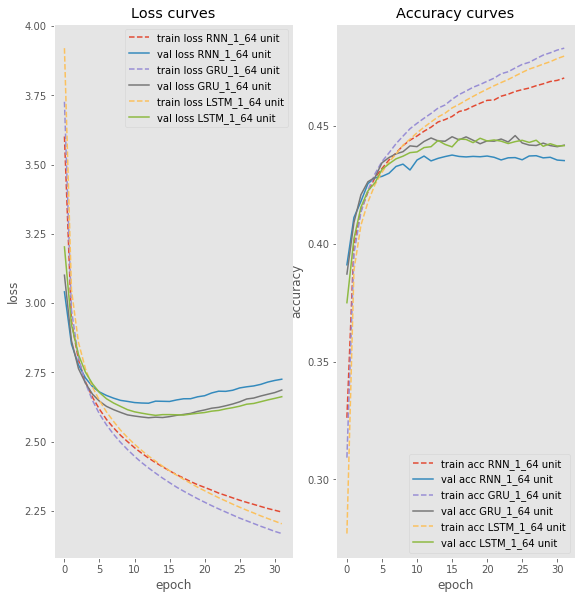

In [0]:
plotLearningCurves_comparison(logs)

In [0]:
# save models 
models['GRU_1_64'].save("/content/gdrive/My Drive/Colab Notebooks/GRU_1_64.h5")
models['RNN_1_64'].save("/content/gdrive/My Drive/Colab Notebooks/RNN_1_64.h5")
models['LSTM_1_64'].save("/content/gdrive/My Drive/Colab Notebooks/LSTM_1_64.h5")

In [0]:
#save logs
with open("/content/gdrive/My Drive/Colab Notebooks/LSTM_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['LSTM_1_64'], file)

with open("/content/gdrive/My Drive/Colab Notebooks/RNN_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['RNN_1_64'], file)

with open("/content/gdrive/My Drive/Colab Notebooks/GRU_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['GRU_1_64'], file)

In [0]:
#load logs
with open("/content/gdrive/My Drive/Colab Notebooks/RNN_128_64_log.pkl", "rb") as file:
    logs['RNN_1_64'] = pickle.load(file)
with open("/content/gdrive/My Drive/Colab Notebooks/GRU_128_64_log.pkl", "rb") as file:
    logs['GRU_1_64'] = pickle.load(file)
with open("/content/gdrive/My Drive/Colab Notebooks/LSTM_128_64_log.pkl", "rb") as file:
    logs['LSTM_1_64'] = pickle.load(file)

In [0]:
# load models
try:
    models['GRU_1_64'] = load_model("/content/gdrive/My Drive/Colab Notebooks/GRU_1_64.h5")
    models['RNN_1_64'] = load_model("/content/gdrive/My Drive/Colab Notebooks/RNN_1_64.h5")
    models['LSTM_1_64'] = load_model("/content/gdrive/My Drive/Colab Notebooks/LSTM_1_64.h5")
except:
    models = {}
    models['GRU_1_64'] = load_model("/content/gdrive/My Drive/Colab Notebooks/GRU_1_64.h5")
    models['RNN_1_64'] = load_model("/content/gdrive/My Drive/Colab Notebooks/RNN_1_64.h5")
    models['LSTM_1_64'] = load_model("/content/gdrive/My Drive/Colab Notebooks/LSTM_1_64.h5")

### Optimal network size

Compare the learning curves for three networks with 64 (previous exercise), 128 and 256 GRUs (single layer) and one with two hidden layers of 64 GRUs. 

**Code** Build and train the networks. Apply EarlyStopping (monitor='val_acc', min_delta=0.001, patience=2). Use transfer learning, do not train from scratch your embedding layer, rather re-use the embedding layer from your best performing network in the last exercise. [4 pts]

**Figure** Show the learning curves (training and validation loss) for the four models. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the four models. [1 pt]

**Question** List and briefly explain the differences in the learning curves for the different models? [2 pts]

**Answer** 

The three new models with transfer learning learn faster than the model which learns from scartch in all learning curves. As they already have a decent embedding (word representation) at the beginning. 

Between the three models with transfer learninig, the single layer 256 GRU model is the fastest and best learner followed by the single layer 128 GRU model, which can be attributed to fact that the larger number of parameters enable the model fit the data quickly. 

With similar parameter numbers, the 2 layer GRU model learns more slowly than 1 layer 128 GRU model. In general a deeper RNN model brings about a better data representation, however in this case it is not the case. We surmise that maybe this involves a vanishing gradient problem.

**Question** What effect had EarlyStopping? Give one advantage and one drawback. [2 pts]

**Answer** 

Early stopping stops training when the monitored metric (validation acc in our case) of the model fails to increase for certain epochs (patience=2), thus all the three model with early stopping stop training at around 10 epochs instead of 32.

One advantage is that It helps avoid overfitting the model heaily and lets us to keep the model with the best generalization ability (best validation score). 

One possible drawback is that if the patience and min_delta parameters are not chosen properly, we may stop training when the model has not been sufficiently trained.

**Question** What is your best model? Why? [1 pt]

**Answer** The singler layer 256 GRU model is the best. It progresses noticeably faster than the other three models in all learning curves and reaches the highest validaiton accuracy record.



In [0]:
#Meta-parameters
embedding_size = 128
hidden_size = 64
dropout = 0.
recurrent_dropout = 0.

batch_size = 64
epochs = 32
validation_split = 0.2

dataset_cut = -1

lr = 1e-3

maxlen = 23
len_dict_list = len(dict_list)
readout_size = 256

In [0]:
pre_embedding = models['GRU_1_64'].get_layer(name='embedding').get_weights()
models['GRU_1_128'] = SingleLayerConstructor(hidden_size=128, readout_size=readout_size, rnn_block='GRU', embedding=pre_embedding)
models['GRU_1_256'] = SingleLayerConstructor(hidden_size=256, readout_size=readout_size, rnn_block='GRU', embedding=pre_embedding)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 22)                0         
_________________________________________________________________
embedding (Embedding)        (None, 22, 128)           129920    
_________________________________________________________________
RNN (GRU)                    (None, 22, 128)           98688     
_________________________________________________________________
readout (TimeDistributed)    (None, 22, 256)           33024     
_________________________________________________________________
output (TimeDistributed)     (None, 22, 1015)          260855    
Total params: 522,487
Trainable params: 392,567
Non-trainable params: 129,920
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #  

In [0]:
# traininig
print(X[:,:-1].shape, T[:,1:].shape)

# early stopping
Early_Stopping = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=2)

# training
logs['GRU_1_128'] = models['GRU_1_128'].fit({'input': X[:dataset_cut, : -1]}, {'output': T[:dataset_cut, 1 :]}, 
                                            epochs=epochs, 
                                            validation_split=validation_split, 
                                            batch_size=batch_size,
                                            callbacks=[Early_Stopping]).history
logs['GRU_1_256'] = models['GRU_1_256'].fit({'input': X[:dataset_cut, : -1]}, {'output': T[:dataset_cut, 1 :]}, 
                                            epochs=epochs, 
                                            validation_split=validation_split, 
                                            batch_size=batch_size,
                                            callbacks=[Early_Stopping]).history

(51008, 22) (51008, 22, 1015)
Train on 40805 samples, validate on 10202 samples
Epoch 1/32
40805/40805 [==============================] - 32s 796us/step - loss: 3.3282 - acc: 0.3588 - val_loss: 2.8642 - val_acc: 0.4085
Epoch 2/32
40805/40805 [==============================] - 29s 723us/step - loss: 2.7652 - acc: 0.4168 - val_loss: 2.7244 - val_acc: 0.4248
Epoch 3/32
40805/40805 [==============================] - 29s 705us/step - loss: 2.6465 - acc: 0.4301 - val_loss: 2.6591 - val_acc: 0.4316
Epoch 4/32
40805/40805 [==============================] - 29s 702us/step - loss: 2.5742 - acc: 0.4381 - val_loss: 2.6232 - val_acc: 0.4383
Epoch 5/32
40805/40805 [==============================] - 29s 721us/step - loss: 2.5228 - acc: 0.4437 - val_loss: 2.6085 - val_acc: 0.4402
Epoch 6/32
40805/40805 [==============================] - 29s 701us/step - loss: 2.4814 - acc: 0.4482 - val_loss: 2.5900 - val_acc: 0.4417
Epoch 7/32
40805/40805 [==============================] - 29s 710us/step - loss: 2.446

In [0]:
I = Input(shape=(maxlen-1,), name="input")
E = Embedding(len_dict_list, embedding_size, mask_zero=True, name="embedding", weights=pre_embedding, trainable=False)(I)
H1 = GRU(units=64, return_sequences=True, 
               recurrent_dropout=recurrent_dropout,
               dropout=dropout,
               name='GRU1')(E)
H2 = GRU(units=64, return_sequences=True, 
               recurrent_dropout=recurrent_dropout,
               dropout=dropout,
               name='GRU2')(H1)

R = TimeDistributed(Dense(units=readout_size, activation='relu'), name='readout')(H2) #... Readout
Y = TimeDistributed(Dense(units=len_dict_list, activation='softmax'), name='output')(R)
    
models['GRU_2_64'] = Model(inputs = [I], outputs = [Y])
opt = Adam() 
models['GRU_2_64'].compile(
  loss='categorical_crossentropy', 
  optimizer=Adam(lr=lr),
  metrics=['acc'])
models['GRU_2_64'].summary()    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 22)                0         
_________________________________________________________________
embedding (Embedding)        (None, 22, 128)           129920    
_________________________________________________________________
GRU1 (GRU)                   (None, 22, 64)            37056     
_________________________________________________________________
GRU2 (GRU)                   (None, 22, 64)            24768     
_________________________________________________________________
readout (TimeDistributed)    (None, 22, 256)           16640     
_________________________________________________________________
output (TimeDistributed)     (None, 22, 1015)          260855    
Total params: 469,239
Trainable params: 339,319
Non-trainable params: 129,920
________________________________________________________________

In [0]:
# traininig
print(X[:,:-1].shape, T[:,1:].shape)
logs['GRU_2_64'] = models['GRU_2_64'].fit({'input': X[:dataset_cut, : -1]}, {'output': T[:dataset_cut, 1 :]}, 
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size,
                                    callbacks=[Early_Stopping]).history

(51008, 22) (51008, 22, 1015)
Train on 40805 samples, validate on 10202 samples
Epoch 1/32
40805/40805 [==============================] - 55s 1ms/step - loss: 3.5078 - acc: 0.3359 - val_loss: 2.9562 - val_acc: 0.4000
Epoch 2/32
40805/40805 [==============================] - 52s 1ms/step - loss: 2.8526 - acc: 0.4077 - val_loss: 2.7914 - val_acc: 0.4172
Epoch 3/32
40805/40805 [==============================] - 52s 1ms/step - loss: 2.7234 - acc: 0.4212 - val_loss: 2.7170 - val_acc: 0.4260
Epoch 4/32
40805/40805 [==============================] - 52s 1ms/step - loss: 2.6500 - acc: 0.4291 - val_loss: 2.6783 - val_acc: 0.4310
Epoch 5/32
40805/40805 [==============================] - 52s 1ms/step - loss: 2.5981 - acc: 0.4352 - val_loss: 2.6447 - val_acc: 0.4338
Epoch 6/32
40805/40805 [==============================] - 52s 1ms/step - loss: 2.5586 - acc: 0.4392 - val_loss: 2.6273 - val_acc: 0.4370
Epoch 7/32
40805/40805 [==============================] - 52s 1ms/step - loss: 2.5256 - acc: 0.443

In [0]:
with open("/content/gdrive/My Drive/Colab Notebooks/GRU_2_64_log.pkl", "wb") as file:
    pickle.dump(logs['GRU_2_64'], file)
with open("/content/gdrive/My Drive/Colab Notebooks/GRU_1_128_log.pkl", "wb") as file:
    pickle.dump(logs['GRU_1_128'], file)
with open("/content/gdrive/My Drive/Colab Notebooks/GRU_1_256_log.pkl", "wb") as file:
    pickle.dump(logs['GRU_1_256'], file)

In [0]:
models['GRU_1_128'].save("/content/gdrive/My Drive/Colab Notebooks/GRU_1_128.h5")
models['GRU_2_64'].save("/content/gdrive/My Drive/Colab Notebooks/GRU_2_64.h5")
models['GRU_1_256'].save("/content/gdrive/My Drive/Colab Notebooks/GRU_1_256.h5")

In [0]:
try:
    with open("/content/gdrive/My Drive/Colab Notebooks/GRU_2_64_log.pkl", "rb") as file:
        logs['GRU_2_64'] = pickle.load(file)
    with open("/content/gdrive/My Drive/Colab Notebooks/GRU_1_128_log.pkl", "rb") as file:
        logs['GRU_1_128'] = pickle.load(file)
    with open("/content/gdrive/My Drive/Colab Notebooks/GRU_1_256_log.pkl", "rb") as file:
        logs['GRU1_256'] = pickle.load(file)
except:
    logs = {}
    with open("/content/gdrive/My Drive/Colab Notebooks/GRU_2_64_log.pkl", "rb") as file:
        logs['GRU_2_64'] = pickle.load(file)
    with open("/content/gdrive/My Drive/Colab Notebooks/GRU_1_128_log.pkl", "rb") as file:
        logs['GRU_1_128'] = pickle.load(file)
    with open("/content/gdrive/My Drive/Colab Notebooks/GRU_1_256_log.pkl", "rb") as file:
        logs['GRU_1_256'] = pickle.load(file)

In [0]:
# load models
try:
    models['GRU_1_128'] = load_model("/content/gdrive/My Drive/Colab Notebooks/GRU_1_128.h5")
    models['GRU_2_64'] = load_model("/content/gdrive/My Drive/Colab Notebooks/GRU_2_64.h5")
    models['GRU_1_256'] = load_model("/content/gdrive/My Drive/Colab Notebooks/GRU_1_256.h5")
except:
    models = {}
    models['GRU_1_128'] = load_model("/content/gdrive/My Drive/Colab Notebooks/GRU_1_128.h5")
    models['GRU_2_64'] = load_model("/content/gdrive/My Drive/Colab Notebooks/GRU_2_64.h5")
    models['GRU_1_256'] = load_model("/content/gdrive/My Drive/Colab Notebooks/GRU_1_256.h5")   

In [0]:
def plotLearningCurves_comparison(logs):
    logs_numb = len(logs)
    fig = plt.figure(figsize=(8, 8))
    axe_train_loss = fig.add_subplot(2, 2, 1)
    axe_val_loss = fig.add_subplot(2, 2, 2)
    axe_train_acc = fig.add_subplot(2, 2, 3)
    axe_val_acc = fig.add_subplot(2, 2, 4)
    
    for (unit_type, log), ind in zip(logs.items(), range(1, logs_numb*2, 2)):   
        # loss
        axe_train_loss.plot(log['loss'], '--', label='train loss '+unit_type+' unit')
        axe_val_loss.plot(log['val_loss'], label='val loss '+unit_type+' unit') 
        
        # acc
        axe_train_acc.plot(log['acc'], '--', label='train acc '+unit_type+' unit')
        axe_val_acc.plot(log['val_acc'], label='val acc '+unit_type+' unit') 
        
    for axe in [axe_train_loss, axe_val_loss, axe_train_acc, axe_val_acc]:
        axehandles, axelabels = axe.get_legend_handles_labels()
        if len(axelabels) > 0:
            axe.legend(axehandles, axelabels)
        axe.set_xlabel('epoch')
             
    axe_train_loss.set_title('Training Loss')
    axe_val_loss.set_title('Validation Loss')
    axe_train_loss.set_ylabel('loss')
    axe_val_loss.set_ylabel('loss')
    
    axe_train_acc.set_title('Training Accuracy')
    axe_train_acc.set_ylabel('accuracy')
    axe_val_acc.set_title('Validation Accuracy')
    axe_val_acc.set_ylabel('Validation Accuracy')
    
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

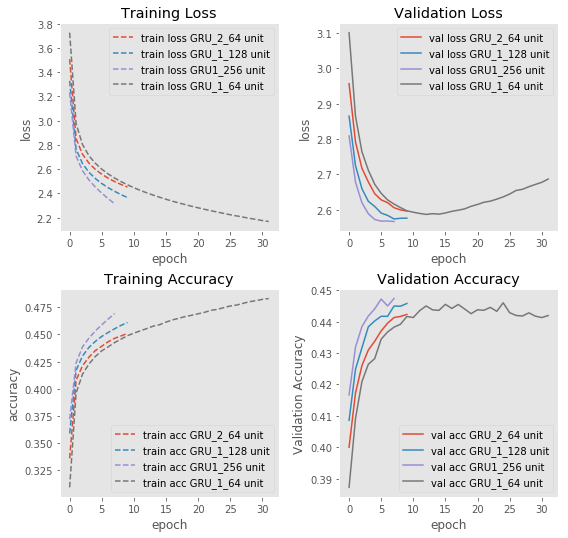

In [0]:
plotLearningCurves_comparison(logs)

### Generate sentences

Now you will generate new sentences from your best performing model.

**Code** To achieve that, use the provided sample function below to generate new sentences from your model. You should start by constructing a sentence that starts with the 'START' artificial word and all other words being the 'PADD' artificial word. Then sample the first word from the corresponding probabilities given by your model. Add this word to the sentence and continue like this until you sample the 'END' artificial word or the maximum sentence length. [2 pts]

**Code** Generate 10 sentences for different sampling temperature in [0., 0.25, 0.5, 0.75, 1., 1.5., 2.]. [1 pt]

**Figures** For each temperature, use matplotlib imshow to plot the probablities of every word in one generated sentence (and only these words) at each time step. y-axis should be the words that are present in the sentence. x-axis the timesteps and the imshow value the probabilities given by the model for all words in the sentence at each timestep. Use the a colormap where 0 is white, e.g. cmap='Greys'. [2 pts]

**Code** Finally, seed your model with two different beginnings of max 4 words and let it generate 10 possible continuations (use sampling temperature of 1.). [2 pts]

**Question** What is the effect of sampling temperature on the generated sentences? [1 pt]

**Answer** Sampling temperature scales the logits input to the softmax function. Compared to a lower temperature, a higher temperature lets the model assign more probability to those classes with relatively smaller logits. Therefore the resulted sentences with high temperature can be more diverse and have more errors. 

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 0 corresponds to? [1 pt] 

**Answer** The word with largest logit will be chosen almost surely.

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 1. corresponds to? [1 pt] 

**Answer** A the softmax probability distribution is computed directly on the unscaled logits.

**Question** In terms of sampling a probability distribution, what does a very high sampling temperature corresponds to? [1 pt]

**Answer** All words tend to be chosen with the close probability.

**Question** Based on the plotted word probabilities, explain how a sentence is generated. [2 pts]

**Answer** At each time step, the model produces a transition probability Pr(word[n+1]|word[:n]). This distribution is across all the words in the dictionary and can be affected by the temperature parameter as discussed above. Then based on the probabilty, the word[n+1] is sampled from a multinominal distribution util the END word is sampled or the specified max length is reached.

**Question** Do you observe timesteps with more than one word with non-zero probability? How do these probable words relate in terms of language? [1 pt]

**Answer** Yes. Ususally, they carry similar meanings and can be considered synonyms in terms of languages.

In [0]:
def sample(preds, temperature=1.):
    # helper function to sample an index from a probability array
    if temperature == 0.:
        return np.argmax(preds), preds

    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas), preds

#### Generate sentences

In [0]:
def generate_sentence(model, beginning, temperature, max_len,dict_list=dict_list):
    
    # Initialize generated sentence for each temperature
    sentence_tokenized = np.zeros([1,max_len-1],dtype=int)
    sentence_resulted = np.zeros([1,max_len],dtype=int)
    tokenized_beginning = list(map(lambda word: dict_list.index(word), beginning.split(' ')))
    i = -1
    token = []
    for ind, num in enumerate(tokenized_beginning):
        sentence_tokenized[0,ind] = num
        sentence_resulted[0,ind] = num
        token.append(num)
        i = i + 1
        
    # list to store the distribution of proba at all time steps
    probas_timestep = []
    
    # Stop criterion: when 'END' is generated or we arrive at the end of a sentence
    while sentence_resulted[0][i] != dict_list.index('END') and i<=max_len-2:
        preds_model = model.predict(sentence_tokenized)
        pred, probas = sample(preds_model[0][i],temperature)
        probas_timestep.append(probas)
        
        # To avoid segmentation fault
        if i<max_len-2:
            sentence_tokenized[0,i+1] = pred
        sentence_resulted[0,i+1] = pred
        i = i+1
        # Store the token to pick out desired probabilities later
        token.append(pred)
    
    token.pop(0)
    # Tranlate the token back to the sentence (a list of words)
    translation = list(map(lambda token: dict_list[token], sentence_resulted[0]))[1:len(token)+1]
    sentence = ' '.join(translation[0:len(token)-1])
    
    print(sentence)
    return sentence, translation, probas_timestep,token

#### Generate 10 sentences for different sampling temperature in [0., 0.25, 0.5, 0.75, 1., 1.5., 2.]

In [0]:
model = models['GRU_2_64']
beginning = 'START'
temperatures = [0., 0.25, 0.5, 0.75, 1., 1.5, 2.]

for temperature in temperatures:
    print('Temperature = ',temperature)
    for i in range(10):
        generate_sentence(model, beginning, max_len=maxlen,temperature=temperature)
    print('--------------------------------------------------------------------')

Temperature =  0.0
i am doing well , how about you ?
i am doing well , how about you ?
i am doing well , how about you ?
i am doing well , how about you ?
i am doing well , how about you ?
i am doing well , how about you ?
i am doing well , how about you ?
i am doing well , how about you ?
i am doing well , how about you ?
i am doing well , how about you ?
--------------------------------------------------------------------
Temperature =  0.25
i am doing well . how about yourself ?
i am doing well . how about you ?
i am doing well , how about you ?
i am doing well . how about you ?
i am doing well , how about you ?
i am good and you ?
i am good , how are you ?
i am doing well , how about you ?
i am doing well , how about you ?
i am good . how about you ?
--------------------------------------------------------------------
Temperature =  0.5
i am doing well , how about you ?
i am doing well . how are you ?
i am great . just got back from a long run !
hi how are you ?
i am good . do you 

 #### For each temperature, use matplotlib imshow to plot the probablities of every word in one generated sentence (and only these words) at each time step.

Generate one sentence for each temperature and record the probabilities

In [0]:
# probas_timestep[i]: Distribution of probabilities at i+1th step
# probas_temp[n]: probas_timestep of n+1th temperature
max_len = 23
translations = []
probas_temp = []
tokens = []

for temperature in temperatures:
    print('Temperature = ',temperature)
    _, translation, probas_timestep, token = generate_sentence(model, beginning, max_len=max_len,temperature=temperature)
    tokens.append(token)
    probas_temp.append(probas_timestep)    
    translations.append(translation)

Temperature =  0.0
i am doing well , how about you ?
Temperature =  0.25
i am good . how about you ?
Temperature =  0.5
that is cool . i love to travel .
Temperature =  0.75
that is great ! what are you studying ?
Temperature =  1.0
nice ! i go to the gym when i have free time . she live up after that is lots .
Temperature =  1.5
well any sweet school at
Temperature =  2.0
either gets great classes way


Plot the probabilities for each sentence.

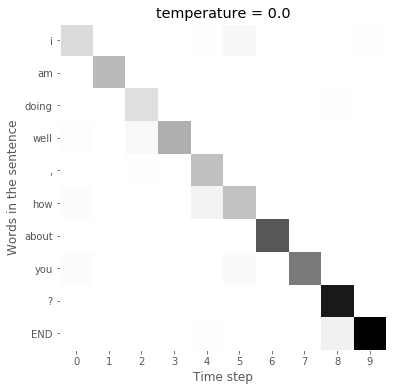

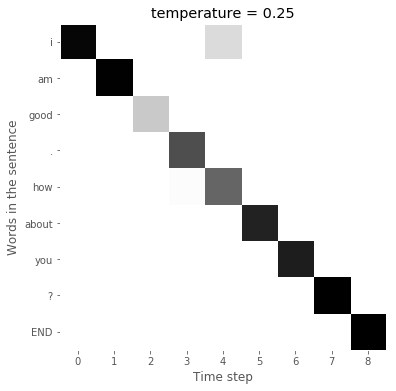

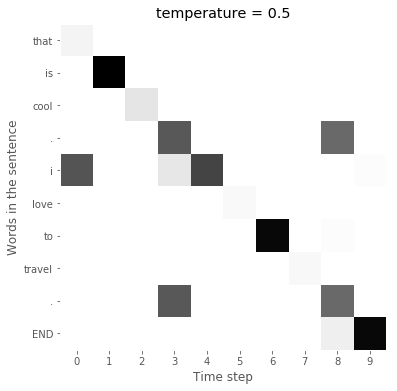

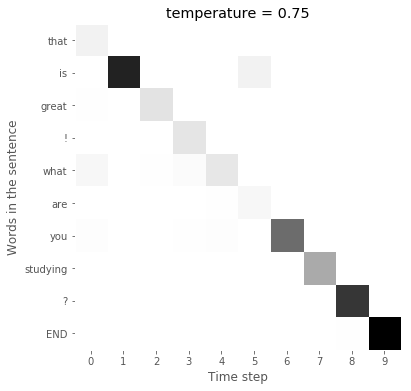

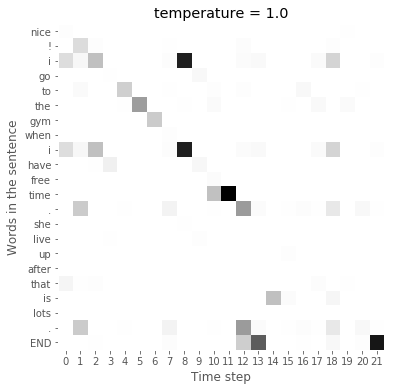

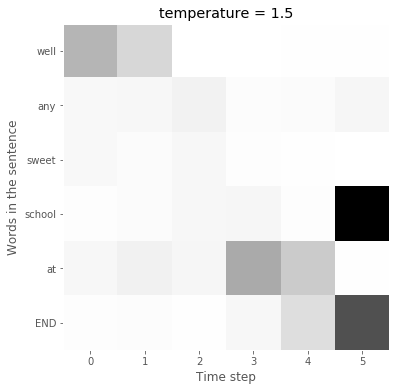

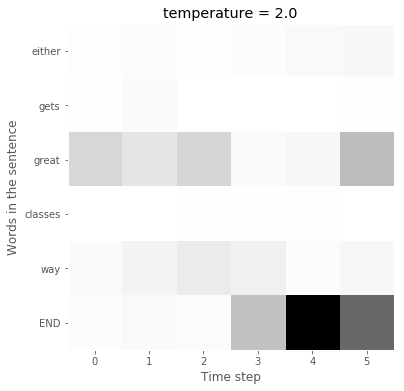

In [0]:
for ind,probas_timestep in enumerate(probas_temp):
    translation = translations[ind]
    token = tokens[ind]
    token = np.array(token)
    prob_temp = np.zeros([len(probas_timestep),len(probas_timestep)])

    for ind_timestep,probas in enumerate(probas_timestep):
        prob_temp[:,ind_timestep] = probas[token.astype(int)]
    fig,ax = plt.subplots(figsize=(6,6))
    ax.set_xticks(range(len(token)))
    ax.set_yticks(range(len(token)))

    ax.set_yticklabels(translation)
    ax.imshow(prob_temp,cmap='Greys')
    ax.set_title("temperature = "+str(temperatures[ind]))
    ax.set_xlabel('Time step')
    ax.set_ylabel('Words in the sentence')

#### Seed the model with two different beginnings of max 4 words and let it generate 10 possible continuations.

In [0]:
model = models['GRU_2_64']
beginning1 = 'START it is'
beginning2 = 'START are you'
max_len=23
temperature = 1
for i in range(10):
    print('beginning: ',beginning1)
    generate_sentence(model, beginning1, temperature, max_len,dict_list=dict_list)
print('----------------------------------------------------------------')
for i in range(10):
    print('beginning: ',beginning2)
    generate_sentence(model, beginning2, temperature, max_len,dict_list=dict_list)

beginning:  START it is
it is so safe . good exercise to yourself .
beginning:  START it is
it is actually nothing long for you ! you are right now i can if you liked it
beginning:  START it is
it is , my cats love that of mexico and god
beginning:  START it is
it is blue but believe . !
beginning:  START it is
it is very nice to i did remember those days
beginning:  START it is
it is a hobby i moved for age because i never boyfriend
beginning:  START it is
it is . i love being a vegetarian .
beginning:  START it is
it is a good idea to give your mind off stuff
beginning:  START it is
it is , if we are from baking . my school restaurant is singing .
beginning:  START it is
it is a totally rock time to be here . do you have plans for well
----------------------------------------------------------------
beginning:  START are you
are you in a date yet ?
beginning:  START are you
are you really good at it ?
beginning:  START are you
are you married ? my dad was and i do not have time for i

###  Word embedding visualization

Here, you are asked to visualize the embedding layer. 

**Code** To do that, project in 2D the embedding vectors for different words. Use t-SNE, a projection that conserve the neighborhood relationships between vectors. HINT: Build a Keras model that takes as input a list of words and outputs a list of vector embeddings as learned by your best performing model. Use t-SNE dimensionality reduction (from sklearn.manifold import TSNE). [2 pts]

**Figure** Plot the projection of the first 200 most frequent words in a 2D plot. On the plot, write the words. [2 pt] 

**Question** Do you observe clusters of words with similar meaning or role in language? Report three of them here. [1 pt]

**Answer** Yes. For example, 'awesome', 'cool' and 'nice';   'pretty', 'so' and 'very';   'do', 'does' and 'did'.

**Question** Why is having similar vector representation for similar words a good approach for such models? Explain using the example clusters from before and argue in terms of prediction accuracy and/or generalization. [2 pts]

**Answer** 

Word embedding allows a good generalization. With similar vector representation for similar words, the model will treat these words simialrly and learn to understand the semantics of these words, thus leading to a better generalization. 

For instance, if the model had encountered the phrase 'do homework' in the training set, during the validation it would be able to assign high probability to 'homework' when encountering 'did' and 'doing' even if 'did homework' and 'doing homework' were not in the training data. Therefore, the model generalizes and makes good prediction when processing input data not in the training set.

#### Plot the projection of the first 200 most frequent words in a 2D plot. On the plot, write the words.

In [0]:
from sklearn.manifold import TSNE
embedding_matrix = models['GRU_2_64'].get_layer(name='embedding').get_weights()

In [0]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embedding_matrix[0])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1015 samples in 0.006s...
[t-SNE] Computed neighbors for 1015 samples in 0.284s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1015
[t-SNE] Computed conditional probabilities for sample 1015 / 1015
[t-SNE] Mean sigma: 1.280956
[t-SNE] KL divergence after 250 iterations with early exaggeration: 96.528549
[t-SNE] KL divergence after 300 iterations: 3.272175


In [0]:
top200 = []
for word,_ in sorted_words[:200]:
    top200.append(word)
top200_token = list(map(lambda word: dict_list.index(word), top200))

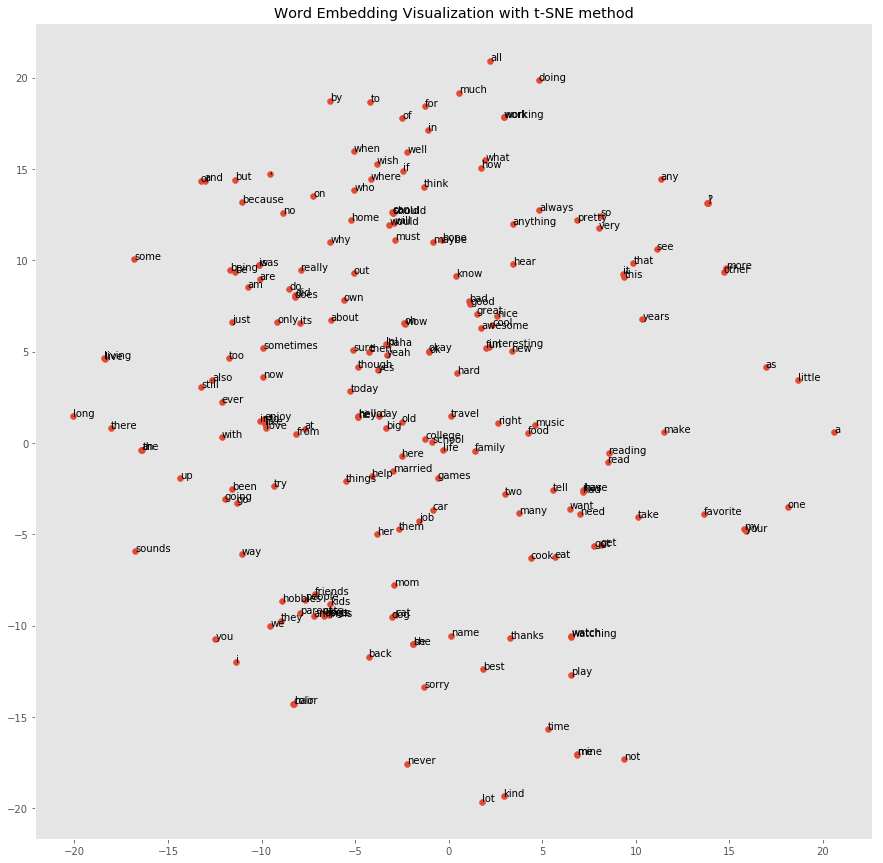

In [0]:
tsne_data = {}
tsne_data["tsne-one"] = tsne_results[:,0]
tsne_data["tsne-two"] = tsne_results[:,1]
tsne_data["y"] = top200_token

fig, ax = plt.subplots(figsize=(15,15))
ax.set_title('Word Embedding Visualization with t-SNE method')
ax.scatter(tsne_results[top200_token,0],tsne_results[top200_token,1])

for i in tsne_data["y"]:
    ax.annotate(dict_list[i], (tsne_data["tsne-one"][i], tsne_data["tsne-two"][i]))

## Chatbot

Finally, you will construct a model with which you can chat. The network will take as input a sentence and output a response.

**Code** For that, you should go back to your original data and construct a new dataset containing pairs of sentences, where each pair is a sentence and its answer. Be careful to not include any pair of sentences that contains words not present in your filtered dictionary. [2 pts]

**Code** You should then tokenize, padd, truncate each sentence. Only the answers need the 'START' and 'END' artificial words. [1 pt]

We provide you with a possible model, you are welcome to change it. This model uses an LSTM layer to encode the first sentence (the context). The final state of this LSTM layer is transfered to initialize the state of a decoder LSTM layer from which the answer sentence will be generated. 

**Code** Train your chatbot model on your dataset. [1 pt]

**Code** Adapt your sentence generation code from before so that you can generate an answer given a context sentence from your model. [2 pts] 

**Code** After training, randomly select 10 context-answers pairs from your data and show both the real answer (the one from the data) and the generated one for two different sampling temperatures (e.g. 0.5 and 1.0). [2 pts]

**Question** How similar are the generated answers and the real ones? Does your model provide probable answers (given the dataset)? Report here one good and one bad example. [2 pts]

**Answer** For a low temperature(0.5), the generated answers are closer to real ones than the answers given under a high temperature (1) in terms of syntax (interrogative sentence or declarative sentence) and vocabulary.  

The model with low temperature generally provides logical answers such as: 

context: that is a cute name . what do you do for work ?
answer: i work at a restaurant.
Real answer: i work in a mexican restaurant . how about you ?

wheras the one with high temperature becomes strange:

context: we should go hiking sometime , i can bring my two dogs with us .
answer: i love italian food is my favorite and dogs ! 
Real Answer:  sounds good to me .

**Question** Which sampling temperature gives better answers? why? [2 pts]

**Answer** The one with temperature 0.5 because most of the answers it gives are grammatically correct and make sense while the answers generated by the model with temperature 1 are less meaningful and usually contain grammatical error regardless of its variety of vocabulary.

**Question** Would it be good if your model was able to reproduce exactly each real answer? Why? [1 pt]

**Answer** No, this suggests that the model has memoried the training data instead of really having learned to respond to the question i.e. it does not have the generalization ability. In this case, if we asked the model a question not in the training set, the model would not be able to produce sensible response as it could generalize.

**Code** Entertain yourself with your model. Write some code to chat with your bot, let it discuss with itself, ... be creative! [2 **bonus** pts]




#### Construct a new dataset of context-answer pairs and exclude the pairs containing words that are not in dict_list

In [0]:
contexts = [conversation[ind] for conversation in conversations for ind in range(len(conversation)-1) ]
answers = [conversation[ind+1] for conversation in conversations for ind in range(len(conversation)-1) ]
    
# Conversation pairs containing words not in dict_list will be removed
ind_removed = set()
for sentence_ind, sentence in enumerate(contexts):
    for word in sentence.split(' '):
        if word not in dict_list:
            ind_removed.add(sentence_ind)
            
for sentence_ind, sentence in enumerate(answers):
    for word in sentence.split(' '):
        if word not in dict_list:
            ind_removed.add(sentence_ind)
        
filtered_contexts = [sentence for ind,sentence in enumerate(contexts) if ind not in ind_removed]
filtered_answers =  [sentence for ind,sentence in enumerate(answers) if ind not in ind_removed]

In [0]:
print(len(filtered_answers))
print(len(filtered_contexts))

19902
19902


#### Add 'START' and 'END' to answers, Tokenization, truncate and padding with respect to maxlen

In [0]:
# add 'START' and 'END' to each sentence 
processed_answers = ['START '+sentence+' END' for sentence in filtered_answers]
  
# Tokenization
tokenized_contexts = []
tokenized_answers = []
for i in range(len(filtered_contexts)):
    tokenized_contexts.append(list(map(lambda word: dict_list.index(word), filtered_contexts[i].split(' '))))
    tokenized_answers.append(list(map(lambda word: dict_list.index(word), processed_answers[i].split(' '))))
    
# Find the maximum length of the sentences
maxlen_contexts = max([len(tokenized_sentence) for tokenized_sentence in tokenized_contexts])
maxlen_answers = max([len(tokenized_sentence) for tokenized_sentence in tokenized_answers])
print(maxlen_contexts,maxlen_answers)

maxlen = max([maxlen_contexts,maxlen_answers])
print('max length is',maxlen)
# post padding (truncation)
padded_tokenized_contexts = pad_sequences(tokenized_contexts, maxlen=maxlen, dtype='int32', padding='post', truncating='post', value=0)
padded_tokenized_answers = pad_sequences(tokenized_answers, maxlen=maxlen, dtype='int32', padding='post', truncating='post', value=0)

23 28
max length is 28


#### Train the model on the dataset

In [0]:
# process training input
X = padded_tokenized_contexts

# process training target
T = list()
for answer in padded_tokenized_answers:
    T.append(to_categorical(answer, num_classes=len(dict_list)))
T = np.array(T)

# answer input: 
answer_input = padded_tokenized_answers

In [0]:
shared_embedding = models['GRU_2_64'].get_layer(name='embedding')
context = Input(shape=(maxlen-2,), name="input_context")
context_embedding = shared_embedding(context)

# hidden state, cell state
encoder_y, encoder_h, encoder_c = LSTM(hidden_size, 
            return_sequences=False,
            return_state=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            go_backwards=True,
            name="encoder")(context_embedding)

answer = Input(shape=(maxlen-1,), name="input_answer")
answer_embedding = shared_embedding(answer)

decoder_input = answer_embedding
decoder = LSTM(hidden_size, 
            return_sequences=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            name="decoder")(answer_embedding, initial_state=[encoder_h, encoder_c])
# decoder2 = LSTM(hidden_size, 
#             return_sequences=True,
#             stateful=False,
#             dropout=dropout,
#             recurrent_dropout=recurrent_dropout,
#             name="decoder2")(decoder)

R = TimeDistributed(Dense(embedding_size, activation='relu'), name='readout')(decoder)
Y = TimeDistributed(Dense(len(dict_list), activation='softmax'), name='output')(R)

models['Chatbot_GRU_1_64'] = Model(inputs = [context, answer], outputs = [Y])
models['Chatbot_GRU_1_64'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['Chatbot_GRU_1_64'].summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_answer (InputLayer)       (None, 27)           0                                            
__________________________________________________________________________________________________
input_context (InputLayer)      (None, 26)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             129920      input_context[0][0]              
                                                                 input_answer[0][0]               
__________________________________________________________________________________________________
encoder (LSTM)                  [(None, 64), (None,  49408       embedding[1][0]                  
__________

In [0]:
logs = {}
logs['Chatbot_GRU_1_64'] = models['Chatbot_GRU_1_64'].fit({'input_context': X[:dataset_cut, : -2], 'input_answer': answer_input[:dataset_cut, : -1]}, {'output':T[:dataset_cut, 1 :]},
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size).history

Train on 15920 samples, validate on 3981 samples
Epoch 1/32
15920/15920 [==============================] - 45s 3ms/step - loss: 4.1396 - acc: 0.2707 - val_loss: 3.3448 - val_acc: 0.3591
Epoch 2/32
15920/15920 [==============================] - 41s 3ms/step - loss: 3.1532 - acc: 0.3792 - val_loss: 3.0179 - val_acc: 0.3961
Epoch 3/32
15920/15920 [==============================] - 41s 3ms/step - loss: 2.9260 - acc: 0.4009 - val_loss: 2.8936 - val_acc: 0.4076
Epoch 4/32
15920/15920 [==============================] - 41s 3ms/step - loss: 2.8078 - acc: 0.4124 - val_loss: 2.8200 - val_acc: 0.4141
Epoch 5/32
15920/15920 [==============================] - 41s 3ms/step - loss: 2.7304 - acc: 0.4203 - val_loss: 2.7791 - val_acc: 0.4196
Epoch 6/32
15920/15920 [==============================] - 41s 3ms/step - loss: 2.6716 - acc: 0.4265 - val_loss: 2.7432 - val_acc: 0.4253
Epoch 7/32
15920/15920 [==============================] - 41s 3ms/step - loss: 2.6227 - acc: 0.4327 - val_loss: 2.7235 - val_acc:

In [0]:
# Save model and logs
models['Chatbot_GRU_1_64'].save("/content/gdrive/My Drive/Colab Notebooks/Chatbot_GRU_1_64.h5")
with open("/content/gdrive/My Drive/Colab Notebooks/Chatbot_GRU_1_64.pkl", "wb") as file:
    pickle.dump(logs['Chatbot_GRU_1_64'], file)

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer decoder was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_5/while/Exit_3:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'encoder_5/while/Exit_4:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [0]:
# Load
try:
    models['Chatbot_GRU_1_64'] = load_model("/content/gdrive/My Drive/Colab Notebooks/Chatbot_GRU_1_64.h5")
except:
    models = {}
    models['Chatbot_GRU_1_64'] = load_model("/content/gdrive/My Drive/Colab Notebooks/Chatbot_GRU_1_64.h5")

#### Generate answer for a given context

In [0]:
def produce_answer(Chatbot, question, maxlen=maxlen, temperature=1):
    
    # Preprocess the question to be in line with the input form
    question = 'START '+question+' END'
    tokenized_question = []
    tokenized_question.append(list(map(lambda word: dict_list.index(word), question.split(' '))))
    padded_tokenized_question = pad_sequences(tokenized_question, maxlen=maxlen-2, dtype='int32', padding='post', truncating='post', value=0)
    
    # Tokenized_input is used as prediction input(len=max_len-1) and tokenized answer is used to store the generated answer(len=max_len)
    tokenized_input = np.zeros([1,maxlen-1],dtype=int)
    tokenized_answer = np.zeros([1,maxlen],dtype=int)
    tokenized_input[0,0] = 1013
    tokenized_answer[0,0] = 1013
    i = 0
    while tokenized_input[0][i] != 1014 and i<maxlen-2:
        preds_model = Chatbot.predict([padded_tokenized_question,tokenized_input])
        pred,probas = sample(preds_model[0][i],temperature = temperature)
        if i<maxlen-2:
            tokenized_input[0,i+1] = pred
        tokenized_answer[0,i+1] = pred
        i = i+1
    len_sentence = i+1
    
    # translate the token back to list of words and truncate the sentence
    translation = list(map(lambda token: dict_list[token], tokenized_answer[0]))[1:len_sentence]
    
    # To avoid a space at the end of the answer which will pose problem to later use
    answer = ' '.join(translation[0:len_sentence-2])
    return answer

In [0]:
Chatbot = models['Chatbot_GRU_1_64']
question = 'how are you doing ?'
for temperature in [0., 0.25, 0.5, 0.75, 1., 1.5, 2.]:
    print(question)
    print('Temperature = ',temperature)
    print('Chatbot answer: ', produce_answer(Chatbot,question,maxlen=28,temperature=temperature))
    print('---------------------------------------------------------------------')

how are you doing ?
Temperature =  0.0
Chatbot answer:  i am good . how are you ?
---------------------------------------------------------------------
how are you doing ?
Temperature =  0.25
Chatbot answer:  i am good . just got done with my daily workout . you ?
---------------------------------------------------------------------
how are you doing ?
Temperature =  0.5
Chatbot answer:  i am good how are you ?
---------------------------------------------------------------------
how are you doing ?
Temperature =  0.75
Chatbot answer:  i am doing very well .
---------------------------------------------------------------------
how are you doing ?
Temperature =  1.0
Chatbot answer:  pretty good . i just got done watching a day farm . what about you ?
---------------------------------------------------------------------
how are you doing ?
Temperature =  1.5
Chatbot answer:  very good and yes . just getting home for the last age , thanks , more today i
-----------------------------------

#### Randomly select 10 context-answers pairs from your data and show both the real answer (the one from the data) and the generated one for two different sampling temperatures (0.5 and 1.0).

In [0]:
# Define Chatbot
Chatbot = models['Chatbot_GRU_1_64']

# Randomly select 10 Question-Answer pairs in dataset
indices = np.random.randint(len(padded_tokenized_contexts),size=10)
contexts_chosen = []
answers_chosen = []
for i in indices:
    contexts_chosen.append(filtered_contexts[i])
    answers_chosen.append(filtered_answers[i])

for temperature in [0.5,1]:
    for ind,context in enumerate(contexts_chosen):
        print('Temperature = ',temperature)
        print('Context: ', context)
        print('Chatbot answer: ', produce_answer(Chatbot, context, maxlen=maxlen, temperature=temperature))
        print('Real Answer: ',answers_chosen[ind])
        print('---------------------------------------------------------------')

Temperature =  0.5
Context:  yeah i am an only child , this is fun . so whats for dinner ?
Chatbot answer:  me to hear . i have a cat . do you have any pets ?
Real Answer:  you are lucky to be a single child
---------------------------------------------------------------
Temperature =  0.5
Context:  hi there , how are you today ?
Chatbot answer:  i am doing good . how about yourself ?
Real Answer:  i am good painting my nails how are you ?
---------------------------------------------------------------
Temperature =  0.5
Context:  oh hey there , did not see you come in .
Chatbot answer:  hello , how are you ?
Real Answer:  hello how are you ?
---------------------------------------------------------------
Temperature =  0.5
Context:  how do they like it ?
Chatbot answer:  do you like music it
Real Answer:  we were born in canada , and moved here . they like running here way better .
---------------------------------------------------------------
Temperature =  0.5
Context:  would you l

#### Chat together!

In [0]:
# Let them chat together
generative_model = models['GRU_2_64']
Chatbot = models['Chatbot_GRU_1_64']
beginning = 'START'
temperature = 0.5
max_len = 23
maxlen = 28
max_iter = 5
print('Temperature = ',temperature)
Chatbot1, _, _, _ = generate_sentence(generative_model, beginning, temperature=temperature, max_len=max_len,dict_list=dict_list)
print('Chatbot1: ',Chatbot1)
for i in range(max_iter):
    Chatbot2 = produce_answer(Chatbot, Chatbot1, maxlen=maxlen, temperature=temperature)
    print('Chatbot2: ', Chatbot2)
    Chatbot1 = produce_answer(Chatbot, Chatbot2, maxlen=maxlen, temperature=temperature)
    print('Chatbot1: ', Chatbot1)

Temperature =  0.5
i am doing well , how about yourself ?
Chatbot1:  i am doing well , how about yourself ?
Chatbot2:  so do not really well .
Chatbot1:  yea , my wife and i do not know how to be there
Chatbot2:  i have not yet . i am in shape off
Chatbot1:  how many children do you have ?
Chatbot2:  i have all girls . i do not have any pets . what about you ?
Chatbot1:  two dogs and two dogs . have a dog person
Chatbot2:  wow , do you have a favorite color ?
Chatbot1:  i like blue , i love them
Chatbot2:  mine is too . i am a teacher .
Chatbot1:  oh nice . what kind of music do you like ?
